# DS 298: Work Assignment - 1
## Statistical Distance Measures and Empirical Distributions

This notebook implements solutions for the homework assignment covering:
1. K-S statistic variation with sample size
2. K-S confusion matrices for different sample sizes
3. Bhattacharyya and Hellinger distance confusion matrices

## Setup and Imports

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import beta as beta_func
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(0)

# Plot settings
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


## Distribution Definitions

We work with three distributions, all with support on (0, 1):

1. **Truncated Normal**: $N(\frac{1}{2}, \frac{3}{6})$ truncated to (0, 1)
2. **Arcsine Distribution**: Beta distribution with $\alpha = \beta = \frac{1}{2}$
3. **Uniform Distribution**: $U(0, 1)$

In [116]:
# Define the three distributions
# 1. Truncated Normal N(1/2, 3/6) truncated to (0, 1)
# Note: N(1/2, 36) seems unusual - interpreting as mean=1/2, variance=1/36 (std=1/6)
mu = 0.5
sigma = 1/6  # Standard deviation (variance = 1/36)
a, b = 0, 1  # Truncation bounds
truncated_normal = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)

# 2. Arcsine Distribution (Beta with alpha = beta = 0.5)
arcsine = stats.beta(0.5, 0.5)

# 3. Uniform Distribution U(0, 1)
uniform = stats.uniform(0, 1)

# Dictionary for easy access
distributions = {
    'Truncated Normal': truncated_normal,
    'Arcsine': arcsine,
    'Uniform': uniform
}

print("Distributions defined:")
for name, dist in distributions.items():
    print(f"  - {name}: mean = {dist.mean():.4f}, var = {dist.var():.4f}")

Distributions defined:
  - Truncated Normal: mean = 0.5000, var = 0.0270
  - Arcsine: mean = 0.5000, var = 0.1250
  - Uniform: mean = 0.5000, var = 0.0833


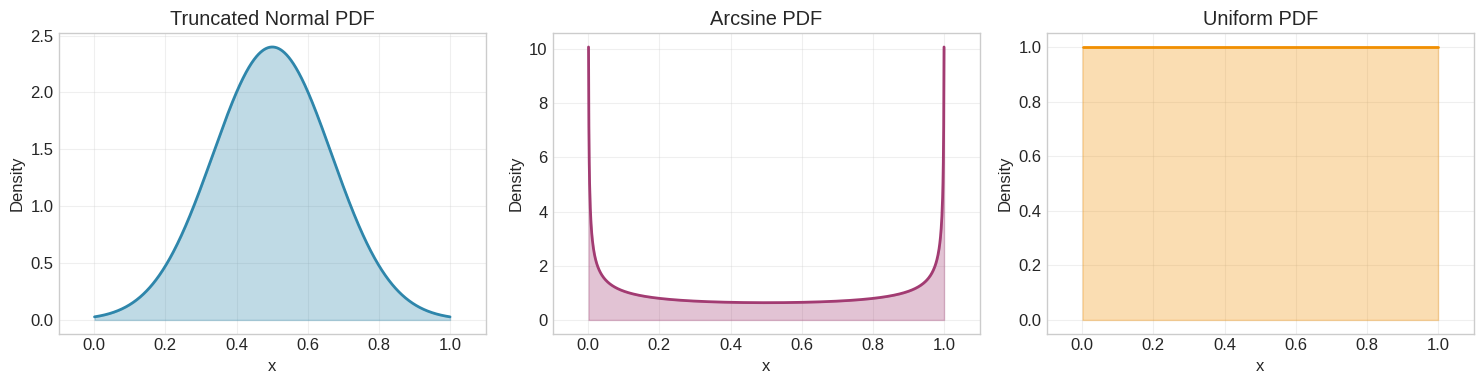

Figure saved as 'distribution_pdfs.png'


In [117]:
# Visualize the PDFs of the three distributions
x = np.linspace(0.001, 0.999, 1000)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

colors = ['#2E86AB', '#A23B72', '#F18F01']
for ax, (name, dist), color in zip(axes, distributions.items(), colors):
    ax.plot(x, dist.pdf(x), color=color, linewidth=2)
    ax.fill_between(x, dist.pdf(x), alpha=0.3, color=color)
    ax.set_title(f'{name} PDF')
    ax.set_xlabel('x')
    ax.set_ylabel('Density')
    ax.set_xlim(-0.1, 1.1)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('distribution_pdfs.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved as 'distribution_pdfs.png'")

## Sampling Functions and Empirical CDF

In [118]:
def sample_distribution(dist_name, n_samples):
    """
    Sample from the specified distribution.
    
    Parameters:
    -----------
    dist_name : str
        Name of the distribution ('Truncated Normal', 'Arcsine', or 'Uniform')
    n_samples : int
        Number of samples to generate
        
    Returns:
    --------
    samples : ndarray
        Array of samples
    """
    return distributions[dist_name].rvs(n_samples)


def empirical_cdf(samples, x):
    """
    Compute the empirical CDF at points x.
    
    Parameters:
    -----------
    samples : ndarray
        Array of samples
    x : ndarray
        Points at which to evaluate the empirical CDF
        
    Returns:
    --------
    ecdf : ndarray
        Empirical CDF values at x
    """
    sorted_samples = np.sort(samples)
    n = len(samples)
    return np.searchsorted(sorted_samples, x, side='right') / n


# Demonstrate sampling
print("Sample demonstration (n=10):")
for name in distributions.keys():
    samples = sample_distribution(name, 10)
    print(f"{name}: {samples[:5]}...")

Sample demonstration (n=10):
Truncated Normal: [0.52038857 0.59448307 0.54329782 0.5187397  0.46799567]...
Arcsine: [6.91437590e-01 3.99293143e-01 5.89310166e-04 2.59019766e-01
 3.30324542e-02]...
Uniform: [0.61209572 0.616934   0.94374808 0.6818203  0.3595079 ]...


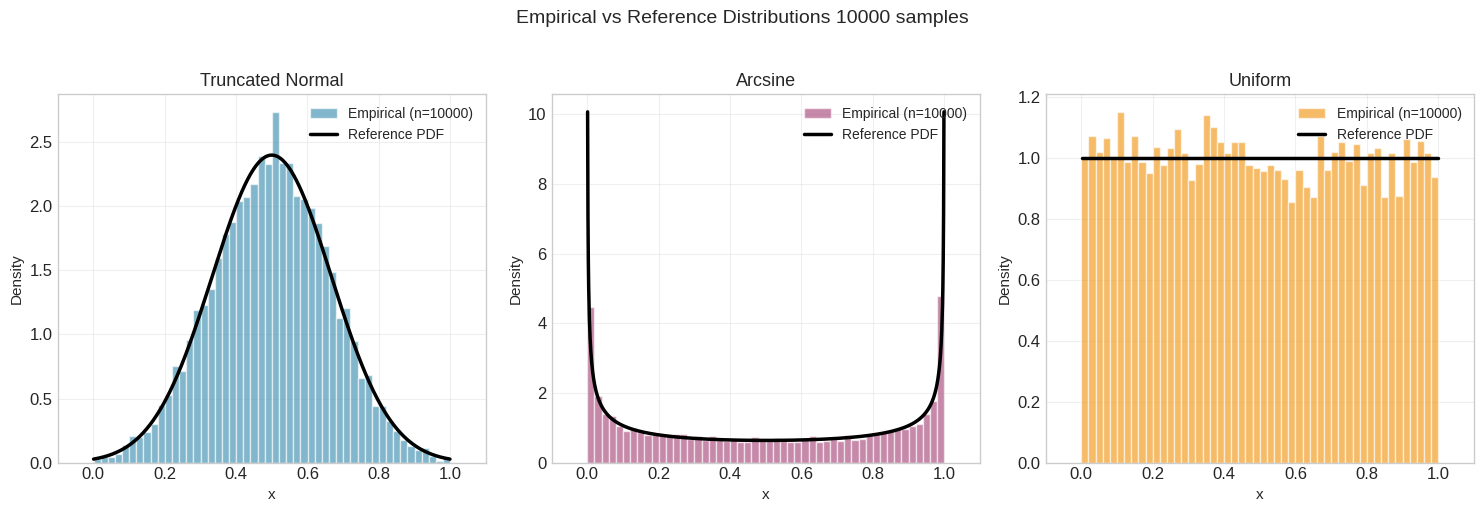

Figure saved as 'empirical_vs_reference.png'


In [131]:
# Plot empirical (histogram) vs reference (PDF) distributions
n_samples_demo = 10000

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
x = np.linspace(0.001, 0.999, 1000)

colors = ['#2E86AB', '#A23B72', '#F18F01']

for ax, (name, dist), color in zip(axes, distributions.items(), colors):
    # Generate samples
    samples = sample_distribution(name, n_samples_demo)
    
    # Plot histogram (empirical distribution)
    ax.hist(samples, bins=50, density=True, alpha=0.6, color=color, 
            edgecolor='white', label=f'Empirical (n={n_samples_demo})')
    
    # Plot reference PDF
    ax.plot(x, dist.pdf(x), color='black', linewidth=2.5, 
            label='Reference PDF', linestyle='-')
    
    ax.set_title(f'{name}', fontsize=13)
    ax.set_xlabel('x', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_xlim(-0.1, 1.1)
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Empirical vs Reference Distributions {n_samples_demo} samples', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(f'empirical_vs_reference_{n_samples_demo}.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved as 'empirical_vs_reference.png'")

## Problem 1: K-S Statistic Variation with Sample Size

The **Kolmogorov-Smirnov (K-S) statistic** measures the maximum absolute difference between the empirical CDF and the reference CDF:

$$D_n = \sup_x |F_n(x) - F(x)|$$

We plot the K-S statistic as the sample size varies from $10^2$ to $10^5$.

In [120]:
def compute_ks_statistic(samples, reference_dist):
    """
    Compute the K-S statistic between samples and a reference distribution.
    
    Parameters:
    -----------
    samples : ndarray
        Array of samples from empirical distribution
    reference_dist : scipy.stats distribution
        Reference distribution for comparison
        
    Returns:
    --------
    ks_stat : float
        K-S statistic value
    """
    ks_stat, _ = stats.kstest(samples, reference_dist.cdf)
    return ks_stat


def compute_ks_vs_n(dist_name, n_values, n_trials=50):
    """
    Compute average K-S statistic for varying sample sizes.
    
    Parameters:
    -----------
    dist_name : str
        Name of the distribution
    n_values : array-like
        Sample sizes to test
    n_trials : int
        Number of trials for averaging
        
    Returns:
    --------
    mean_ks : ndarray
        Mean K-S statistic for each sample size
    std_ks : ndarray
        Standard deviation of K-S statistic for each sample size
    """
    mean_ks = []
    std_ks = []
    
    for n in n_values:
        ks_values = []
        for _ in range(n_trials):
            samples = sample_distribution(dist_name, int(n))
            ks = compute_ks_statistic(samples, distributions[dist_name])
            ks_values.append(ks)
        mean_ks.append(np.mean(ks_values))
        std_ks.append(np.std(ks_values))
    
    return np.array(mean_ks), np.array(std_ks)

print("K-S computation functions defined.")

K-S computation functions defined.


In [121]:
# Sample sizes from 10^2 to 10^5 (logarithmically spaced)
n_values = np.logspace(2, 5, 30).astype(int)
n_trials = 100  # Number of trials for averaging

print(f"Computing K-S statistics for sample sizes from {n_values[0]} to {n_values[-1]}...")
print(f"Using {n_trials} trials for averaging...")

# Compute K-S statistics for each distribution
ks_results = {}
for name in distributions.keys():
    print(f"  Processing {name}...")
    mean_ks, std_ks = compute_ks_vs_n(name, n_values, n_trials)
    ks_results[name] = {'mean': mean_ks, 'std': std_ks}

print("Done!")

Computing K-S statistics for sample sizes from 100 to 100000...
Using 100 trials for averaging...
  Processing Truncated Normal...
  Processing Arcsine...
  Processing Uniform...
Done!


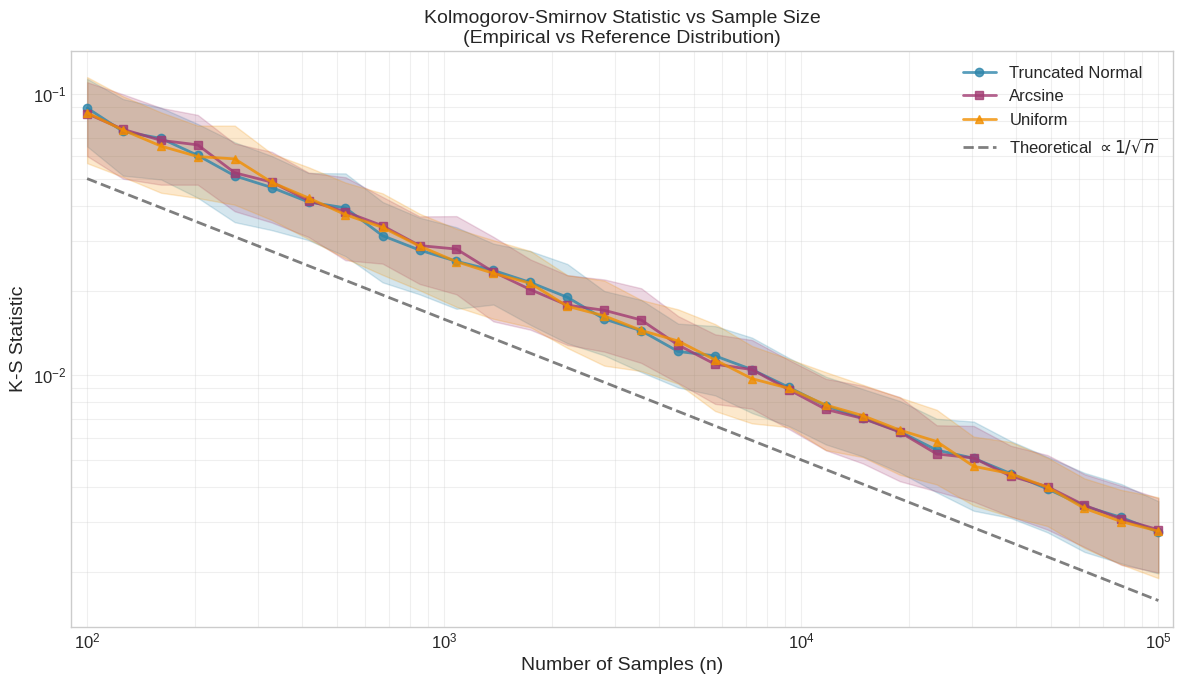

Figure saved as 'ks_vs_sample_size.png'


In [122]:
# Plot K-S statistic variation with sample size
fig, ax = plt.subplots(figsize=(12, 7))

colors = ['#2E86AB', '#A23B72', '#F18F01']
markers = ['o', 's', '^']

for (name, result), color, marker in zip(ks_results.items(), colors, markers):
    mean_ks = result['mean']
    std_ks = result['std']
    
    ax.loglog(n_values, mean_ks, marker=marker, color=color, 
              label=name, linewidth=2, markersize=6, alpha=0.8)
    ax.fill_between(n_values, mean_ks - std_ks, mean_ks + std_ks, 
                    color=color, alpha=0.2)

# Add theoretical reference line: K-S statistic ~ 1/sqrt(n)
theoretical = 0.5 / np.sqrt(n_values)
ax.loglog(n_values, theoretical, 'k--', linewidth=2, alpha=0.5, 
          label=r'Theoretical $\propto 1/\sqrt{n}$')

ax.set_xlabel('Number of Samples (n)', fontsize=14)
ax.set_ylabel('K-S Statistic', fontsize=14)
ax.set_title('Kolmogorov-Smirnov Statistic vs Sample Size\n(Empirical vs Reference Distribution)', fontsize=14)
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, which='both', alpha=0.3)
ax.set_xlim(0.9*n_values[0], n_values[-1]*1.1)

plt.tight_layout()
plt.savefig('ks_vs_sample_size.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved as 'ks_vs_sample_size.png'")

### Observations - Problem 1

1. **Convergence**: The K-S statistic decreases as the sample size increases for all three distributions, confirming that empirical distributions converge to their reference distributions.

2. **Rate of Convergence**: The decay follows approximately $O(1/\sqrt{n})$, consistent with the Dvoretzky-Kiefer-Wolfowitz inequality.

3. **Distribution Comparison**: All three distributions show similar convergence rates, though the Arcsine distribution (with its U-shaped PDF) may show slightly higher variance in the K-S statistic estimates.

## Problem 2: K-S Confusion Matrix

Generate 3×3 symmetric confusion matrices comparing each empirical distribution with all three reference distributions for sample sizes $10^2$, $10^3$, and $10^4$.

In [123]:
def compute_ks_confusion_matrix(n_samples, n_trials=100):
    """
    Compute K-S confusion matrix comparing all distributions.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to use
    n_trials : int
        Number of trials for averaging
        
    Returns:
    --------
    matrix : ndarray
        3x3 confusion matrix of K-S statistics
    """
    dist_names = list(distributions.keys())
    matrix = np.zeros((3, 3))
    
    for i, emp_name in enumerate(dist_names):
        for j, ref_name in enumerate(dist_names):
            ks_values = []
            for _ in range(n_trials):
                samples = sample_distribution(emp_name, n_samples)
                ks_stat = compute_ks_statistic(samples, distributions[ref_name])
                ks_values.append(ks_stat)
            matrix[i, j] = np.mean(ks_values)
    
    return matrix


# Compute confusion matrices for different sample sizes
sample_sizes = [100, 1000, 10000]
ks_matrices = {}

print("Computing K-S confusion matrices...")
for n in sample_sizes:
    print(f"  n = {n}...")
    ks_matrices[n] = compute_ks_confusion_matrix(n, n_trials=100)

print("Done!")

Computing K-S confusion matrices...
  n = 100...
  n = 1000...
  n = 10000...
Done!


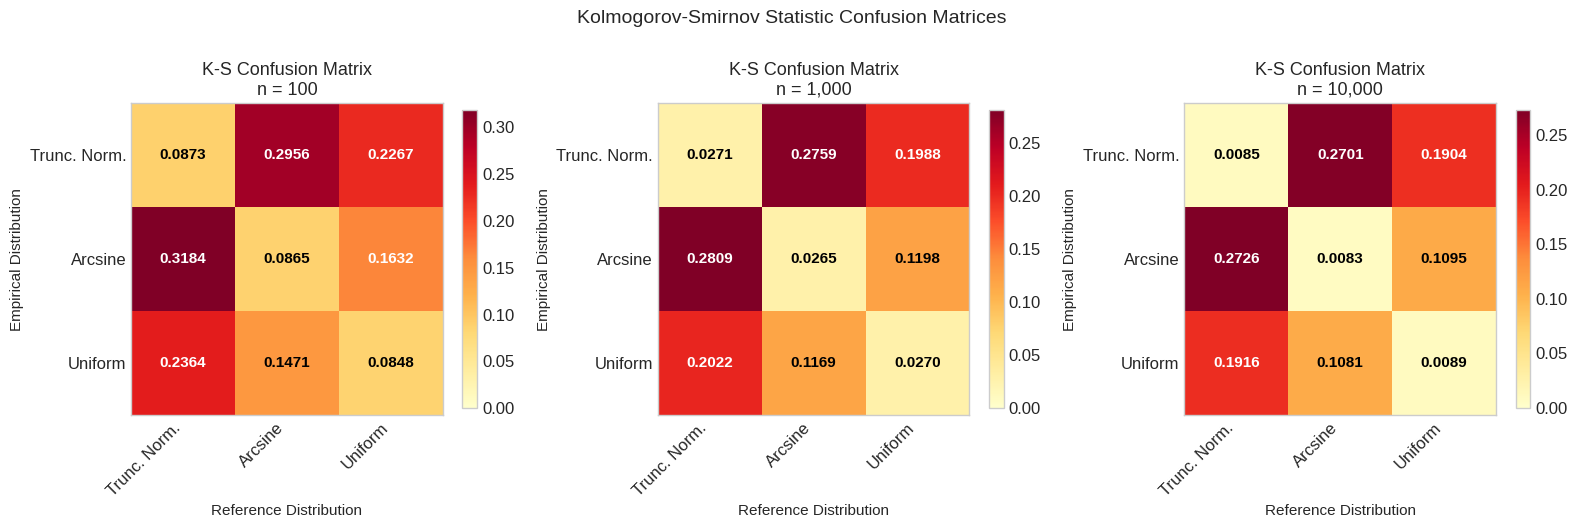

Figure saved as 'ks_confusion_matrices.png'


In [124]:
# Display K-S confusion matrices
dist_names = list(distributions.keys())

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, n in zip(axes, sample_sizes):
    matrix = ks_matrices[n]
    im = ax.imshow(matrix, cmap='YlOrRd', vmin=0)
    
    # Add text annotations
    for i in range(3):
        for j in range(3):
            color = 'white' if matrix[i, j] > matrix.max() * 0.5 else 'black'
            ax.text(j, i, f'{matrix[i, j]:.4f}', ha='center', va='center', 
                    fontsize=11, color=color, fontweight='bold')
    
    ax.set_xticks(range(3))
    ax.set_yticks(range(3))
    ax.set_xticklabels(['Trunc. Norm.', 'Arcsine', 'Uniform'], rotation=45, ha='right')
    ax.set_yticklabels(['Trunc. Norm.', 'Arcsine', 'Uniform'])
    ax.set_xlabel('Reference Distribution', fontsize=11)
    ax.set_ylabel('Empirical Distribution', fontsize=11)
    ax.set_title(f'K-S Confusion Matrix\nn = {n:,}', fontsize=13)
    ax.grid(False)
    
    plt.colorbar(im, ax=ax, shrink=0.8)

plt.suptitle('Kolmogorov-Smirnov Statistic Confusion Matrices', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('ks_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved as 'ks_confusion_matrices.png'")

In [125]:
# Print K-S confusion matrices as tables
print("K-S Statistic Confusion Matrices")
print("=" * 70)

header = "Empirical \\ Reference"
for n in sample_sizes:
    print(f"\nn = {n:,}")
    print("-" * 60)
    print(f"{header:<20} {'Trunc. Normal':>14} {'Arcsine':>14} {'Uniform':>14}")
    print("-" * 60)
    
    for i, name in enumerate(['Trunc. Normal', 'Arcsine', 'Uniform']):
        row = ks_matrices[n][i]
        print(f"{name:<20} {row[0]:>14.4f} {row[1]:>14.4f} {row[2]:>14.4f}")
    print()

K-S Statistic Confusion Matrices

n = 100
------------------------------------------------------------
Empirical \ Reference  Trunc. Normal        Arcsine        Uniform
------------------------------------------------------------
Trunc. Normal                0.0873         0.2956         0.2267
Arcsine                      0.3184         0.0865         0.1632
Uniform                      0.2364         0.1471         0.0848


n = 1,000
------------------------------------------------------------
Empirical \ Reference  Trunc. Normal        Arcsine        Uniform
------------------------------------------------------------
Trunc. Normal                0.0271         0.2759         0.1988
Arcsine                      0.2809         0.0265         0.1198
Uniform                      0.2022         0.1169         0.0270


n = 10,000
------------------------------------------------------------
Empirical \ Reference  Trunc. Normal        Arcsine        Uniform
-------------------------------

### Observations - Problem 2

1. **Diagonal Elements**: The diagonal elements (where empirical and reference distributions match) show the smallest K-S statistics, decreasing as sample size increases.

2. **Off-diagonal Elements**: Large off-diagonal values indicate significant differences between distributions. The Arcsine distribution shows the highest K-S statistics when compared to other distributions due to its distinctive U-shaped PDF.

3. **Distinguishability**: As sample size increases, the contrast between diagonal and off-diagonal elements increases, making distribution identification more reliable.

## Problem 3: Bhattacharyya and Hellinger Distance Confusion Matrices

### Distance Definitions

**Bhattacharyya Distance**:
$$D_B(p, q) = -\ln\left(\sum_x \sqrt{p(x) \cdot q(x)}\right)$$

**Hellinger Distance**:
$$H(p, q) = \sqrt{1 - \sum_x \sqrt{p(x) \cdot q(x)}} = \sqrt{1 - BC(p,q)}$$

where $BC(p,q) = \sum_x \sqrt{p(x) \cdot q(x)}$ is the Bhattacharyya coefficient.

In [126]:
def compute_histogram_pdf(samples, n_bins=100):
    """
    Compute histogram-based PDF estimate from samples.
    
    Parameters:
    -----------
    samples : ndarray
        Array of samples
    n_bins : int
        Number of histogram bins
        
    Returns:
    --------
    bin_centers : ndarray
        Center of each bin
    pdf_estimate : ndarray
        Normalized PDF estimate at each bin center
    """
    counts, bin_edges = np.histogram(samples, bins=n_bins, range=(0, 1), density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Normalize to sum to 1 (as discrete probability)
    pdf_estimate = counts * bin_width
    return bin_centers, pdf_estimate


def bhattacharyya_distance(p, q):
    """
    Compute Bhattacharyya distance between two discrete distributions.
    
    Parameters:
    -----------
    p, q : ndarray
        Discrete probability distributions (must sum to 1)
        
    Returns:
    --------
    distance : float
        Bhattacharyya distance
    """
    # Add small epsilon to avoid log(0)
    eps = 1e-10
    bc = np.sum(np.sqrt(p * q))  # Bhattacharyya coefficient
    bc = np.clip(bc, eps, 1.0)
    return -np.log(bc)


def hellinger_distance(p, q):
    """
    Compute Hellinger distance between two discrete distributions.
    
    Parameters:
    -----------
    p, q : ndarray
        Discrete probability distributions (must sum to 1)
        
    Returns:
    --------
    distance : float
        Hellinger distance
    """
    bc = np.sum(np.sqrt(p * q))  # Bhattacharyya coefficient
    return np.sqrt(np.maximum(0, 1 - bc))


print("Distance functions defined.")

Distance functions defined.


In [127]:
def compute_distance_confusion_matrix(n_samples, distance_func, n_trials=100, n_bins=100):
    """
    Compute distance confusion matrix comparing all distributions.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to use
    distance_func : callable
        Distance function to use (bhattacharyya_distance or hellinger_distance)
    n_trials : int
        Number of trials for averaging
    n_bins : int
        Number of histogram bins
        
    Returns:
    --------
    matrix : ndarray
        3x3 confusion matrix of distances
    """
    dist_names = list(distributions.keys())
    matrix = np.zeros((3, 3))
    
    # Pre-compute reference PDFs at bin centers
    bin_centers = np.linspace(0.5/n_bins, 1 - 0.5/n_bins, n_bins)
    bin_width = 1.0 / n_bins
    
    ref_pdfs = {}
    for name, dist in distributions.items():
        ref_pdf = dist.pdf(bin_centers) * bin_width  # Discrete probability
        ref_pdf = ref_pdf / ref_pdf.sum()  # Normalize
        ref_pdfs[name] = ref_pdf
    
    for i, emp_name in enumerate(dist_names):
        for j, ref_name in enumerate(dist_names):
            distance_values = []
            for _ in range(n_trials):
                samples = sample_distribution(emp_name, n_samples)
                _, emp_pdf = compute_histogram_pdf(samples, n_bins)
                # Normalize empirical PDF
                emp_pdf = emp_pdf / (emp_pdf.sum() + 1e-10)
                distance = distance_func(emp_pdf, ref_pdfs[ref_name])
                distance_values.append(distance)
            matrix[i, j] = np.mean(distance_values)
    
    return matrix


# Compute Bhattacharyya and Hellinger distance matrices for n=10^4
n_samples = 10000
n_trials = 100

print(f"Computing distance confusion matrices for n = {n_samples:,}...")

print("  Computing Bhattacharyya distances...")
bhatt_matrix = compute_distance_confusion_matrix(n_samples, bhattacharyya_distance, n_trials)

print("  Computing Hellinger distances...")
hellinger_matrix = compute_distance_confusion_matrix(n_samples, hellinger_distance, n_trials)

print("Done!")

Computing distance confusion matrices for n = 10,000...
  Computing Bhattacharyya distances...
  Computing Hellinger distances...
Done!


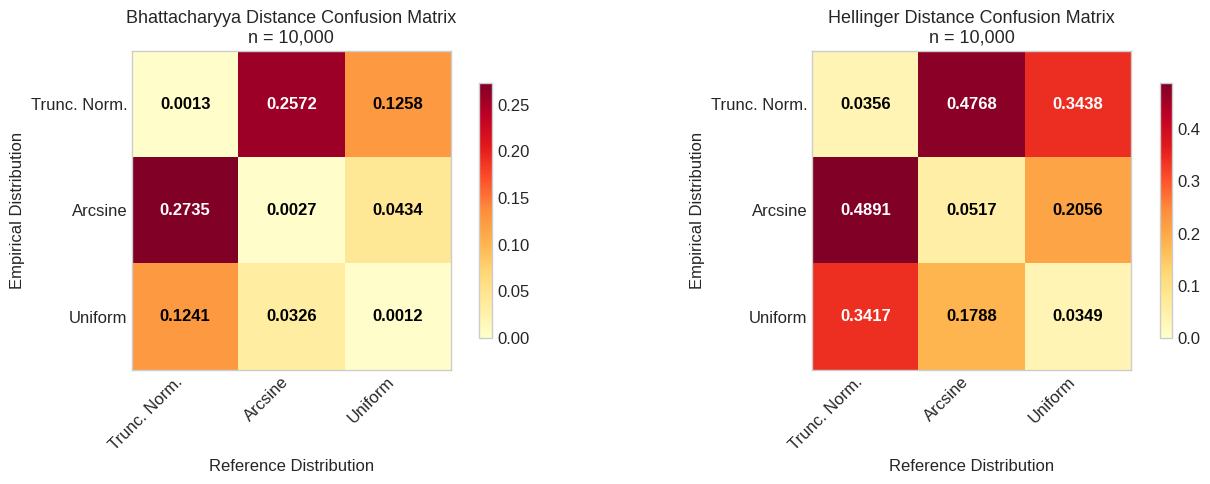

Figure saved as 'distance_confusion_matrices.png'


In [128]:
# Display distance confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

matrices = [bhatt_matrix, hellinger_matrix]
titles = ['Bhattacharyya Distance', 'Hellinger Distance']

for ax, matrix, title in zip(axes, matrices, titles):
    im = ax.imshow(matrix, cmap='YlOrRd', vmin=0)
    
    # Add text annotations
    for i in range(3):
        for j in range(3):
            color = 'white' if matrix[i, j] > matrix.max() * 0.5 else 'black'
            ax.text(j, i, f'{matrix[i, j]:.4f}', ha='center', va='center', 
                    fontsize=12, color=color, fontweight='bold')
    
    ax.set_xticks(range(3))
    ax.set_yticks(range(3))
    ax.set_xticklabels(['Trunc. Norm.', 'Arcsine', 'Uniform'], rotation=45, ha='right')
    ax.set_yticklabels(['Trunc. Norm.', 'Arcsine', 'Uniform'])
    ax.set_xlabel('Reference Distribution', fontsize=12)
    ax.set_ylabel('Empirical Distribution', fontsize=12)
    ax.set_title(f'{title} Confusion Matrix\nn = {n_samples:,}', fontsize=13)
    ax.grid(False)

    plt.colorbar(im, ax=ax, shrink=0.8)

plt.tight_layout()
plt.savefig('distance_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved as 'distance_confusion_matrices.png'")

In [129]:
# Print distance confusion matrices as tables
print("Distance Confusion Matrices (n = 10,000)")
print("=" * 70)

header = "Empirical \\ Reference"

print("\nBhattacharyya Distance:")
print("-" * 60)
print(f"{header:<20} {'Trunc. Normal':>14} {'Arcsine':>14} {'Uniform':>14}")
print("-" * 60)
for i, name in enumerate(['Trunc. Normal', 'Arcsine', 'Uniform']):
    row = bhatt_matrix[i]
    print(f"{name:<20} {row[0]:>14.4f} {row[1]:>14.4f} {row[2]:>14.4f}")

print("\n\nHellinger Distance:")
print("-" * 60)
print(f"{header:<20} {'Trunc. Normal':>14} {'Arcsine':>14} {'Uniform':>14}")
print("-" * 60)
for i, name in enumerate(['Trunc. Normal', 'Arcsine', 'Uniform']):
    row = hellinger_matrix[i]
    print(f"{name:<20} {row[0]:>14.4f} {row[1]:>14.4f} {row[2]:>14.4f}")

Distance Confusion Matrices (n = 10,000)

Bhattacharyya Distance:
------------------------------------------------------------
Empirical \ Reference  Trunc. Normal        Arcsine        Uniform
------------------------------------------------------------
Trunc. Normal                0.0013         0.2572         0.1258
Arcsine                      0.2735         0.0027         0.0434
Uniform                      0.1241         0.0326         0.0012


Hellinger Distance:
------------------------------------------------------------
Empirical \ Reference  Trunc. Normal        Arcsine        Uniform
------------------------------------------------------------
Trunc. Normal                0.0356         0.4768         0.3438
Arcsine                      0.4891         0.0517         0.2056
Uniform                      0.3417         0.1788         0.0349


### Observations - Problem 3

1. **Diagonal Elements**: Both Bhattacharyya and Hellinger distances show near-zero values on the diagonal (matching distributions), with small non-zero values due to sampling variance.

2. **Distance Relationship**: The Hellinger distance is bounded by [0, 1], while Bhattacharyya distance is unbounded above. For distributions that are very different, Bhattacharyya distance can be quite large.

3. **Arcsine Distinctiveness**: The Arcsine distribution shows the largest distances when compared with other distributions due to its concentration at the boundaries (0 and 1).

4. **Uniform-Truncated Normal Similarity**: The Uniform and Truncated Normal distributions show moderate distances, as both have relatively flat profiles in the middle of the interval.

## Summary and Conclusions

### Key Findings:

1. **K-S Statistic Behavior**: The K-S statistic decreases proportionally to $1/\sqrt{n}$ as sample size increases, consistent with theoretical predictions. All three distributions exhibit similar convergence behavior.

2. **Distribution Identification**: The confusion matrices demonstrate that distributions can be reliably distinguished using statistical distances. The diagonal elements (correct matches) consistently show smaller values than off-diagonal elements.

3. **Distance Measure Comparison**:
   - **K-S statistic**: Measures maximum CDF deviation, good for detecting overall distributional differences
   - **Bhattacharyya distance**: Based on overlap of PDFs, unbounded, sensitive to distribution shape
   - **Hellinger distance**: Bounded [0,1], provides normalized measure of distributional difference

4. **Distribution Characteristics**:
   - The Arcsine distribution is most distinct due to its U-shaped PDF
   - Uniform and Truncated Normal distributions are more similar to each other
   - All distances decrease with increasing sample size, indicating convergence

### Practical Implications:
- For hypothesis testing, K-S test is appropriate when comparing empirical to theoretical distributions
- For measuring similarity between distributions, Hellinger distance provides a more interpretable bounded metric
- Sample sizes of 10,000+ provide reliable distance estimates with low variance

In [130]:
# Final summary of all results
print("=" * 70)
print("HOMEWORK 1 - COMPLETE RESULTS SUMMARY")
print("=" * 70)

print("\n1. K-S Statistics at n=10,000 (diagonal elements):")
for i, name in enumerate(['Truncated Normal', 'Arcsine', 'Uniform']):
    print(f"   {name}: {ks_matrices[10000][i,i]:.6f}")

print("\n2. Distance measures at n=10,000 (diagonal elements):")
for i, name in enumerate(['Truncated Normal', 'Arcsine', 'Uniform']):
    print(f"   {name}: Bhattacharyya={bhatt_matrix[i,i]:.6f}, Hellinger={hellinger_matrix[i,i]:.6f}")

print("\n3. Generated Figures:")
print("   - distribution_pdfs.png")
print("   - ks_vs_sample_size.png")
print("   - ks_confusion_matrices.png")
print("   - distance_confusion_matrices.png")

print("\n" + "=" * 70)
print("Homework completed successfully!")
print("=" * 70)

HOMEWORK 1 - COMPLETE RESULTS SUMMARY

1. K-S Statistics at n=10,000 (diagonal elements):
   Truncated Normal: 0.008548
   Arcsine: 0.008311
   Uniform: 0.008936

2. Distance measures at n=10,000 (diagonal elements):
   Truncated Normal: Bhattacharyya=0.001281, Hellinger=0.035550
   Arcsine: Bhattacharyya=0.002728, Hellinger=0.051673
   Uniform: Bhattacharyya=0.001243, Hellinger=0.034851

3. Generated Figures:
   - distribution_pdfs.png
   - ks_vs_sample_size.png
   - ks_confusion_matrices.png
   - distance_confusion_matrices.png

Homework completed successfully!
